In [1]:
# import libraries and data
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.transforms import Resize
from imutils import paths
import random
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import statistics

from tqdm import tqdm
import time

print(torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# determine if pinning memory during data loading
pin_memory = True if device == "cuda:0" else False

True


In [2]:
! pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  U

In [3]:
# import the necessary packages
from torch.utils.data import Dataset
import cv2

class TumorDataset(Dataset):
    def __init__(self, image_paths, label_paths, transforms):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        label = cv2.imread(self.label_paths[idx], cv2.IMREAD_GRAYSCALE)

        if self.transforms is not None:
            image = self.transforms[0](image)
            label = self.transforms[1](label)
        return (image, label)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -q /content/drive/MyDrive/BT_segmentation_dataset.zip

Mounted at /content/drive


In [13]:
img_size = (1, 256, 256)

# Train set
train_images = sorted(list(paths.list_images(os.path.join("/content/BT_segmentation_dataset", "train/images"))))
train_labels = sorted(list(paths.list_images(os.path.join("/content/BT_segmentation_dataset", "train/labels"))))

# Test set
test_images = sorted(list(paths.list_images(os.path.join("/content/BT_segmentation_dataset", "test/images"))))
test_labels = sorted(list(paths.list_images(os.path.join("/content/BT_segmentation_dataset", "test/labels"))))

img_transform = transforms.Compose([transforms.ToPILImage(), Resize(img_size[1:], Image.BILINEAR), transforms.ToTensor()])
label_transform = transforms.Compose([transforms.ToPILImage(), Resize(img_size[1:], Image.NEAREST), transforms.PILToTensor()])

# create the train and test datasets
trainset = TumorDataset(image_paths=train_images, label_paths=train_labels,	transforms=(img_transform, label_transform))
testset = TumorDataset(image_paths=test_images, label_paths=test_labels, transforms=(img_transform, label_transform))

# create the training and test data loaders
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=8, pin_memory=pin_memory)
testloader = torch.utils.data.DataLoader(testset, shuffle=True, 	batch_size=8, pin_memory=pin_memory)

print(f'Found {len(trainset)} examples in the trainset.')
print(f'Found {len(testset)} examples in the testset.')

Found 3235 examples in the trainset.
Found 832 examples in the testset.


In [6]:
a = torch.eq(torch.tensor([[1, 2], [3, 4]]), torch.tensor([[1, 1], [4, 4]])).int()
print(a.sum().item())
print(a.numel())
print(a.sum().item()/a.numel())

2
4
0.5


In [7]:
class EarlyStopping:
    def __init__(self, patience=4, min_delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                               Default: 0
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [40]:
class CrossEntropyLoss2d(torch.nn.Module):
    def __init__(self, weights=torch.ones(2).to(device)):
        super().__init__()
        self.loss = torch.nn.NLLLoss(weights)

    def forward(self, outputs, targets):
        return self.loss(torch.nn.functional.log_softmax(outputs, dim=1), targets)


class BinaryCrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = torch.nn.BCELoss()

    def forward(self, outputs, targets):
        return self.loss(outputs, targets)


class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super().__init__()
        self.smooth = smooth

    def forward(self, outputs, targets):
        outputs = torch.argmax(outputs, dim=1).squeeze(1) #outputs: BxHxW ; targets: BxHxW
        intersection =  (outputs*targets).sum()
        dice_score = (2.0 * intersection + self.smooth) / (outputs.sum().item() + targets.sum().item() + self.smooth)
        return 1 - dice_score


class DiceCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_ce = CrossEntropyLoss2d()
        self.loss_dl = DiceLoss()

    def forward(self, outputs, targets):
        loss = self.loss_ce(outputs, targets) + self.loss_dl(outputs, targets)
        return loss


def compute_ious(predictions, targets):

    predictions = torch.argmax(predictions, dim=1)

    # Check only the tumor class
    bs = predictions.shape[0]
    ious = []
    for i in range(bs):
        pred = predictions[i]
        target = targets[i]

        intersect = ((pred == 1) & (target == 1)).sum().item()
        fp = ((pred == 1) & (target != 1)).sum().item()
        fn = ((pred != 1) & (target == 1)).sum().item()
        union = fp + fn + intersect

        # Calculate the Intersection over Union
        iou =  1.0 if intersect == 0 and union == 0 else intersect / union
        ious.append(iou)
    return ious

In [41]:
def plot_loss_accuracy(train_loss, validation_loss, validation_acc):
    epochs = len(train_loss)
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 8))
    plt.setp((ax1, ax2), xticks=range(0, epochs+1))

    ax1.plot(list(range(1, epochs+1)), train_loss, label='Training Loss')
    ax1.plot(list(range(1, epochs+1)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss vs Epoch')
    ax1.legend()

    ax2.plot(list(range(1, epochs+1)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy vs Epoch')
    ax2.legend(loc= 'lower right')
    ax2.set_ylim([0, 1])
    fig.tight_layout()

    plt.show()


def evaluate(model=None, dataloader=None, criterion=None, device='cpu', report_pth=None):

    running_val_loss = 0.0
    IOU = []
    m = nn.Sigmoid()

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        model.eval()
        for j, data in enumerate(dataloader):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # calculate outputs by running images through the network
            outputs = model(images)

            loss = criterion(outputs, labels.squeeze(1).long())
            running_val_loss += loss.item()

            IOU.extend(compute_ious(outputs, labels.squeeze(1).long()))

    #Validation loss
    val_loss = running_val_loss / (j+1)

    #mean IOU and loss
    return statistics.mean(IOU), val_loss


def train(model=None, epochs=1, trainloader=None, valloader=None, device='cpu', save_pth=None, verbose=0, csv_path=None):
    #loss function
    criterion = DiceCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    train_epoch_loss = []
    val_epoch_loss = []
    val_epoch_mIOU = []

    best_iou = 0.0
    nb = len(trainloader)  # number of batches

    # Evaluate the model once before training
    best_mIOU, _ = evaluate(model, valloader, criterion, device)

    # Training logs
    train_log = []
    train_log.append({
        'epoch': 0,
        'train_loss': 'nan',
        'val_loss': 'nan',
        'val_mIOU': best_mIOU})

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=4, min_delta=0.0001)

    # Start training
    t0 = time.time()

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        pbar = enumerate(trainloader)
        if verbose: print(('\n' + '%10s' * 2) % ('Epoch', 'mloss'))
        pbar = tqdm(pbar, total=nb, bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}') if verbose else pbar  # progress bar
        running_loss = 0.0
        running_val_loss = 0.0

        for i, data in pbar:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze(1).long())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            if verbose: pbar.set_description(('%10s' * 2) % (f'{epoch + 1}/{epochs}', f'{running_loss / (i+1):.3f}'))

        train_epoch_loss.append(running_loss / (i+1))

        #Evaluate at the end of the epoch
        fi, vloss = evaluate(model, valloader, criterion, device)
        if verbose: print(('%20s') % (f'mean IOU : {100 * fi:.3f} %'))

        val_epoch_mIOU.append(fi)
        val_epoch_loss.append(vloss)

        if fi > best_iou:
            best_iou = fi
            if save_pth != None:
                torch.save(model.state_dict(), save_pth)

        # Early stopping check
        early_stopping(val_epoch_loss[-1])
        if early_stopping.early_stop:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

    if verbose:
        print(f'\n{epoch+1} epochs completed in {(time.time() - t0) / 3600:.3f} hours.')
        #Plot the loss and accuracy for every epoch
        plot_loss_accuracy(train_epoch_loss, val_epoch_loss, val_epoch_mIOU)

    if csv_path is not None:
        import pandas as pd
        # Append train log data
        for ep in range(epoch+1):
            train_log.append({
                'epoch': ep + 1,
                'train_loss': train_epoch_loss[ep],
                'val_loss': val_epoch_loss[ep],
                'val_mIOU': val_epoch_mIOU[ep]})

        # Convert to DataFrame
        df = pd.DataFrame(train_log)

        # Save to CSV
        df.to_csv(csv_path, index=False)
        print(f'Training logs saved to {csv_path}')

    #Load the saved model
    model.load_state_dict(torch.load(save_pth, map_location=device))
    best_mIOU, _ = evaluate(model, valloader, criterion, device)
    print(('%20s') % (f'Final evaluation, mIOU : {100 * best_mIOU:.3f} %'))

    return best_mIOU


def visualise_data(dataloader):
    # Display images and labels from the train dataset.
    batch = next(iter(dataloader))

    fig = plt.figure(figsize=(8, 8))
    for i in range(4):
        #get the image and label
        image = batch[0][i].numpy()
        image = image.transpose((1, 2, 0)) #CxHxW -> HxWxC
        image = (image * 255.0).astype("uint8")

        label = batch[1][i].numpy()
        label = label.transpose((1, 2, 0)) #CxHxW -> HxWxC
        label = (label * 255).astype("uint8")

        fig.add_subplot(2, 4, i+1)
        plt.title('image')
        plt.axis("off")
        plt.imshow(image, cmap='gray')

        fig.add_subplot(2, 4, i+1+4)
        plt.title('label')
        plt.axis("off")
        plt.imshow(label, cmap='gray')

    fig.tight_layout()
    plt.show()
    plt.close()


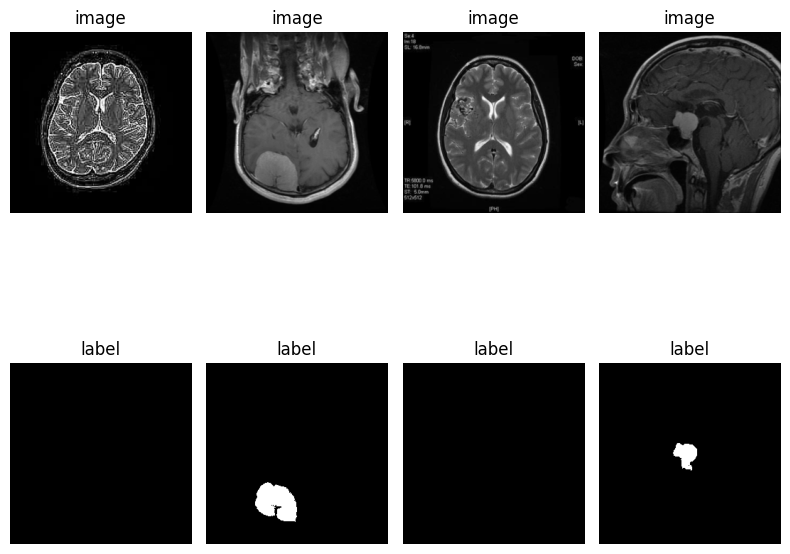

In [14]:
# Display images and labels from the train dataset.
visualise_data(trainloader)

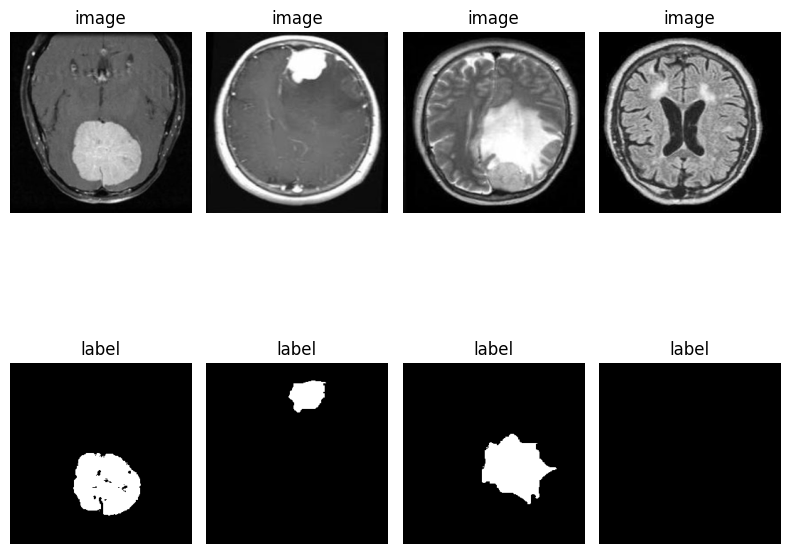

In [15]:

# Display images and labels from the test dataset.
visualise_data(testloader)

In [42]:
model = smp.Unet(
    encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

model = model.to(device)

In [43]:
#Dry run to inspect the model
x = torch.randn(img_size).unsqueeze(0).to(device) #1xcxhxw
out = model(x)


     Epoch     mloss


      1/15     0.467: 100%|██████████| 405/405 [01:03<00:00,  6.43it/s]


 mean IOU : 77.877 %

     Epoch     mloss


      2/15     0.120: 100%|██████████| 405/405 [01:00<00:00,  6.65it/s]


 mean IOU : 92.107 %

     Epoch     mloss


      3/15     0.095: 100%|██████████| 405/405 [01:00<00:00,  6.66it/s]


 mean IOU : 92.741 %

     Epoch     mloss


      4/15     0.081: 100%|██████████| 405/405 [01:00<00:00,  6.67it/s]


 mean IOU : 93.345 %

     Epoch     mloss


      5/15     0.076: 100%|██████████| 405/405 [01:00<00:00,  6.65it/s]


 mean IOU : 93.639 %

     Epoch     mloss


      6/15     0.069: 100%|██████████| 405/405 [01:00<00:00,  6.65it/s]


 mean IOU : 94.001 %

     Epoch     mloss


      7/15     0.065: 100%|██████████| 405/405 [01:00<00:00,  6.67it/s]


 mean IOU : 94.152 %

     Epoch     mloss


      8/15     0.059: 100%|██████████| 405/405 [01:00<00:00,  6.66it/s]


 mean IOU : 94.244 %

     Epoch     mloss


      9/15     0.056: 100%|██████████| 405/405 [01:00<00:00,  6.66it/s]


 mean IOU : 94.280 %

     Epoch     mloss


     10/15     0.055: 100%|██████████| 405/405 [01:01<00:00,  6.57it/s]


 mean IOU : 94.384 %

     Epoch     mloss


     11/15     0.051: 100%|██████████| 405/405 [01:00<00:00,  6.66it/s]


 mean IOU : 94.585 %

     Epoch     mloss


     12/15     0.053: 100%|██████████| 405/405 [01:00<00:00,  6.68it/s]


 mean IOU : 94.155 %

     Epoch     mloss


     13/15     0.051: 100%|██████████| 405/405 [01:00<00:00,  6.69it/s]


 mean IOU : 94.791 %

     Epoch     mloss


     14/15     0.047: 100%|██████████| 405/405 [01:00<00:00,  6.68it/s]


 mean IOU : 94.664 %

     Epoch     mloss


     15/15     0.053: 100%|██████████| 405/405 [01:00<00:00,  6.68it/s]


 mean IOU : 94.560 %

15 epochs completed in 0.278 hours.


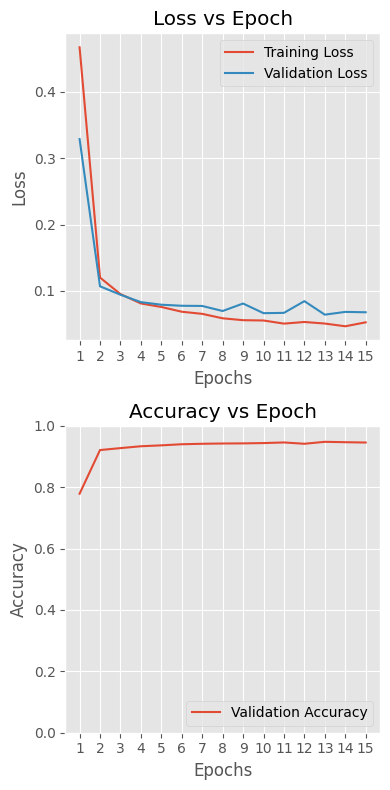

Training logs saved to /content/segment.csv
Final evaluation, mIOU : 94.791 %
Model best mIOU = 0.9479125591668733


In [44]:
#Train
mIOU = train(model=model, epochs=15, trainloader=trainloader, valloader=testloader, device=device, save_pth='/content/best_model_segment.pth', verbose=1, csv_path='/content/segment.csv')
print(f'Model best mIOU = {mIOU}')

In [45]:
#Load the saved model
# Here strict=False because you get some unexpected_keys due to 'thop' which can be ignored.
model.load_state_dict(torch.load('/content/best_model_segment.pth'), strict=False)

IOU = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    model.eval()
    for j, data in enumerate(testloader):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = model(images)

        IOU.extend(compute_ious(outputs, labels.squeeze(1).long()))

print(('%20s') % (f'mean IOU : {100 * statistics.mean(IOU):.3f} %'))

 mean IOU : 94.791 %


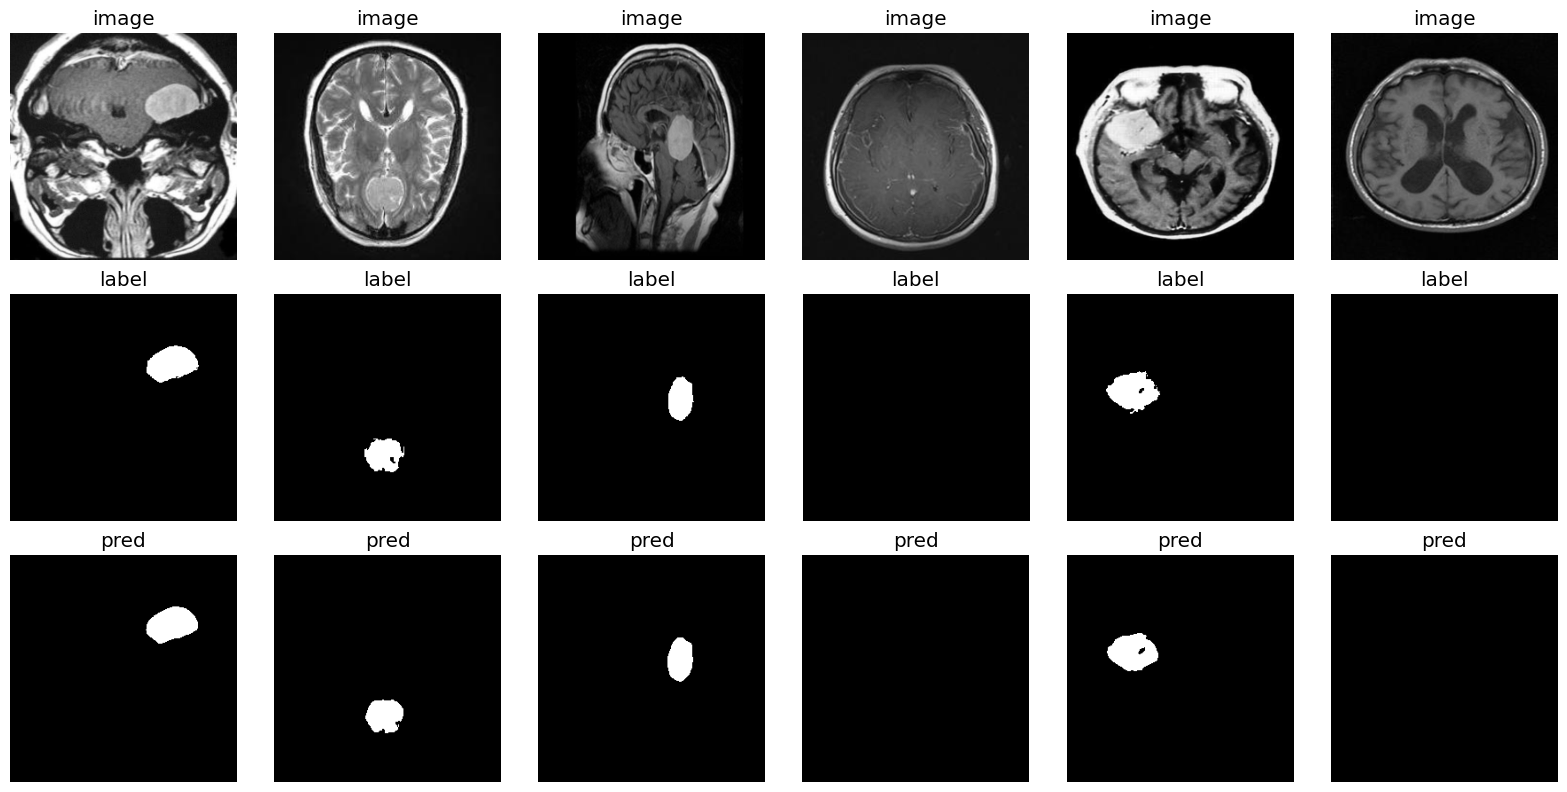

In [46]:
fig = plt.figure(figsize=(16, 8))
with torch.no_grad():
    model.eval()
    batch = next(iter(testloader))

    for i in range(6):
        #get the image and label
        image = batch[0][i].numpy()
        image = image.transpose((1, 2, 0)) #CxHxW -> HxWxC
        image = (image * 255.0).astype("uint8")

        label = batch[1][i].numpy()
        label = label.transpose((1, 2, 0)) #CxHxW -> HxWxC
        label = (label * 255).astype("uint8")

        # calculate outputs by running images through the network
        output = model(batch[0][i].unsqueeze(0).to(device))
        pred =  torch.argmax(output, dim=1).cpu().numpy()
        pred = pred.transpose((1, 2, 0)) #CxHxW -> HxWxC
        pred = (pred * 255).astype("uint8")

        fig.add_subplot(3, 6, i+1)
        plt.title('image')
        plt.axis("off")
        plt.imshow(image, cmap='gray')

        fig.add_subplot(3, 6, i+1+6)
        plt.title('label')
        plt.axis("off")
        plt.imshow(label, cmap='gray')

        fig.add_subplot(3, 6, i+1+12)
        plt.title('pred')
        plt.axis("off")
        plt.imshow(pred, cmap='gray')

fig.tight_layout()
plt.show()
plt.close()


In [48]:
#!cp /content/best_model_segment.pth /content/drive/MyDrive/
!cp /content/segment.csv /content/drive/MyDrive/